## FinBERT Sentiment Scoring Text Data
This Python code utilizes the FinBERT model to perform sentiment scoring on preprocessed text data from a CSV file. The code loads the FinBERT model, reads the input CSV file containing preprocessed text data, and then applies FinBERT sentiment scoring on both the 'text' column and the 'processed_text' column. The code extracts the sentiments and scores from the FinBERT predictions and saves the results to a new CSV file, allowing for easy comparison of sentiment analysis on the original and preprocessed text data. The preprocessing steps include removing cashtags, user mentions, URLs, emojis, and handling repeated characters, ensuring that the text data is clean and ready for sentiment analysis.

### 1. Before applying FinBERT sentiment scoring let check how many rows have None values in processed text column

In [164]:
import pandas as pd
from tabulate import tabulate
from colorama import Fore, Style


# Read the CSV file into a pandas DataFrame
df = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\Stocks\stocks\NVDA\NVDA_3\processed_Nvidia_3.csv')

# Count the number of None values in the 'processed_text' column
num_none_values = df['processed_text'].isnull().sum()

# Get the total number of values in the 'processed_text' column
total_values = len(df['processed_text'])

# Calculate the percentage of None values
percentage_none_values = (num_none_values / total_values) * 100

# Calculate the percentage of None values
after_removing_none = (total_values - num_none_values)

# Create a table with the information
table = [
    ["Total", total_values],
    ["Number of None", num_none_values],
    ["Percentage of None", f"{percentage_none_values:.2f}%"],
    ["After removing None values", after_removing_none]
]

# Print the table with colored output
print(Fore.BLUE + tabulate(table, headers=["Description (values in column 'processed_text')", " Values"], tablefmt="fancy_grid") + Style.RESET_ALL)




╒═══════════════════════════════════════════════════╤═══════════╕
│ Description (values in column 'processed_text')   │  Values   │
╞═══════════════════════════════════════════════════╪═══════════╡
│ Total                                             │ 100226    │
├───────────────────────────────────────────────────┼───────────┤
│ Number of None                                    │ 4321      │
├───────────────────────────────────────────────────┼───────────┤
│ Percentage of None                                │ 4.31%     │
├───────────────────────────────────────────────────┼───────────┤
│ After removing None values                        │ 95905     │
╘═══════════════════════════════════════════════════╧═══════════╛


In [159]:
df.tail(10)

,id,text,time,sentiment,processed_text
90317,534986467,$NVDA 422 \nSometimes its best to let the boy...,2023-07-07,NaN,422 sometimes its best to let the boys fight i...
90318,534986082,$SPY They revised April and May jobs numbers l...,2023-07-07,Bullish,they revised april and may jobs numbers lower ...
90319,534985112,$NVDA I do think China and US are trying to fo...,2023-07-07,Bearish,i do think china and us are trying to force ea...
90320,534984692,$NVDA let&#39;s see a healthy 10 percent dip t...,2023-07-07,Bearish,let39s see a healthy 10 percent dip today
90321,534984666,$NVDA whole structure from 400-440 is getting ...,2023-07-07,NaN,whole structure from 400440 is getting tighter...
90322,534984526,@modrica3 they changed the business model a bi...,2023-07-07,NaN,modrica3 they changed the business model a bit...
90323,534979564,$NVDA what the fuck is this piece of shit doing,2023-07-07,NaN,what the fuck is this piece of shit doing
90324,534988716,$NVDA Bulls are looking to get some good excer...,2023-07-07,Bearish,bulls are looking to get some good excercise i...
90325,534986480,"$NVDA $550 easy by next week , possible !! Not...",2023-07-07,Bullish,550 easy by next week possible nothing to stop...
90326,534983944,"$TSLA Enron has never left Twittor, he is stil...",2023-07-07,Bearish,enron has never left twittor he is still much ...


## 2. Applying FinBERT model to predict sentiment and score on processed text file

In [165]:
import os
import pandas as pd
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from tqdm import tqdm  # Import tqdm for the progress bar

# Step 1: Load the FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Step 2: Input and Output file paths
input_file_path = r'C:\Users\sahma\Desktop\Thises\Stocks\stocks\NVDA\NVDA_3\processed_Nvidia_3.csv'
output_file_name = 'finbert_processed_Nvidia_3.csv'

# Get the folder path of the input file
folder_path = os.path.dirname(input_file_path)

# Full path for the output file
output_file_path = os.path.join(folder_path, output_file_name)

# Step 3: Read the CSV file into a pandas DataFrame
df = pd.read_csv(input_file_path)

# Step 4: Remove rows with None values in 'processed_text' column
df = df.dropna(subset=['processed_text'])

# Step 5: Tokenize the text and perform sentiment analysis using FinBERT
batch_size = 32  # Set your desired batch size based on your available memory
total_rows = len(df)

# Initialize the progress bar
with tqdm(total=total_rows, desc="Processing Rows", unit="row") as pbar:
    # Loop through the DataFrame in batches
    for i in range(0, total_rows, batch_size):
        batch_df = df.iloc[i:i+batch_size]  # Get the current batch

        # Tokenize the text data
        encoded_texts = tokenizer(batch_df['processed_text'].tolist(), padding=True, truncation=True, return_tensors="pt", max_length=512)

        # Perform sentiment analysis using FinBERT
        with torch.no_grad():
            outputs = model(**encoded_texts)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

        # Map sentiment labels to sentiment names
        label_names = model.config.id2label.values()
        label_names = [label.replace("LABEL_", "") for label in label_names]
        sentiment_labels = [label_names[prediction.item()] for prediction in predictions]

        # Get only the highest probability from the finbert_score list
        max_sentiment_scores = [max(scores) for scores in logits.softmax(dim=-1).tolist()]

        # Add the FinBERT sentiment labels and scores to the DataFrame
        for j, idx in enumerate(batch_df.index):
            df.at[idx, 'finbert_sentiment'] = sentiment_labels[j]
            df.at[idx, 'finbert_score'] = max_sentiment_scores[j]

        # Update the progress bar
        pbar.update(len(batch_df))

# Step 6: Save the updated DataFrame to a new CSV file
df.to_csv(output_file_path, index=False)

# Print completion message
print(f"FinBERT sentiment analysis completed. The processed data has been saved to '{output_file_path}'.")


Processing Rows: 100%|██████████| 95905/95905 [5:02:57<00:00,  5.28row/s]  


FinBERT sentiment analysis completed. The processed data has been saved to 'C:\Users\sahma\Desktop\Thises\Stocks\stocks\NVDA\NVDA_3\finbert_processed_Nvidia_3.csv'.


In [15]:
import pandas as pd
df = pd.read_csv(r"C:\Users\sahma\Desktop\Thises\5.5_NVDA\finbert_processed_Nvidia_4.csv")

In [16]:
df.head()

,id,text,time,sentiment,processed_text,finbert_sentiment,finbert_score
0,440095047,Sweep Options Activity: $NVDA is the #18 ticke...,2022-02-28,NaN,sweep options activity is the 18 ticker with s...,Neutral,0.999992
1,440090156,$NVDA I’m so bullish,2022-02-28,Bullish,i am so bullish,Positive,0.999613
2,440090065,$NVDA boys I’m so bullish,2022-02-28,Bullish,boys i am so bullish,Positive,0.999798
3,440086959,$PLUG $tsla $arkk $f $NVDA \n \nIf Putin will...,2022-02-28,NaN,if putin will kill his own brothers then what ...,Neutral,0.999860
4,440086726,$NVDA give me a 10% day tmr pls 👀,2022-02-28,Bullish,give me a 10 day tomorrow pls,Neutral,0.999995


In [17]:
df.tail()

,id,text,time,sentiment,processed_text,finbert_sentiment,finbert_score
97847,496644313,$NVDA amazing this went green at all with reve...,2022-11-16,Bearish,amazing this went green at all with revenues d...,Negative,0.999638
97848,496629362,$NVDA 🤣🤣🤣 Nothing burger???,2022-11-16,NaN,nothing burger,Neutral,0.921472
97849,496644495,$NVDA how is this seriously not down $20?,2022-11-16,NaN,how is this seriously not down 20,Negative,0.662610
97850,496644485,$NVDA sell before 162.00 breakdown,2022-11-16,NaN,sell before 16200 breakdown,Neutral,0.998660
97851,496644269,$NVDA They missed on EPS and reduced guidance....,2022-11-16,Bearish,they missed on eps and reduced guidance gltu n...,Negative,0.999995


## 3. Map sentiment class to numarical values

In [18]:
# Map the 'finbert_sentiment' column to numerical representations
sentiment_mapping = {
    'Positive': 1,
    'Negative': -1,
    'Neutral': 0
}

In [19]:
df['sentiment_num'] = df['finbert_sentiment'].map(sentiment_mapping)

In [20]:
df.head()

,id,text,time,sentiment,processed_text,finbert_sentiment,finbert_score,sentiment_num
0,440095047,Sweep Options Activity: $NVDA is the #18 ticke...,2022-02-28,NaN,sweep options activity is the 18 ticker with s...,Neutral,0.999992,0
1,440090156,$NVDA I’m so bullish,2022-02-28,Bullish,i am so bullish,Positive,0.999613,1
2,440090065,$NVDA boys I’m so bullish,2022-02-28,Bullish,boys i am so bullish,Positive,0.999798,1
3,440086959,$PLUG $tsla $arkk $f $NVDA \n \nIf Putin will...,2022-02-28,NaN,if putin will kill his own brothers then what ...,Neutral,0.999860,0
4,440086726,$NVDA give me a 10% day tmr pls 👀,2022-02-28,Bullish,give me a 10 day tomorrow pls,Neutral,0.999995,0


In [21]:
df.tail()

,id,text,time,sentiment,processed_text,finbert_sentiment,finbert_score,sentiment_num
97847,496644313,$NVDA amazing this went green at all with reve...,2022-11-16,Bearish,amazing this went green at all with revenues d...,Negative,0.999638,-1
97848,496629362,$NVDA 🤣🤣🤣 Nothing burger???,2022-11-16,NaN,nothing burger,Neutral,0.921472,0
97849,496644495,$NVDA how is this seriously not down $20?,2022-11-16,NaN,how is this seriously not down 20,Negative,0.662610,-1
97850,496644485,$NVDA sell before 162.00 breakdown,2022-11-16,NaN,sell before 16200 breakdown,Neutral,0.998660,0
97851,496644269,$NVDA They missed on EPS and reduced guidance....,2022-11-16,Bearish,they missed on eps and reduced guidance gltu n...,Negative,0.999995,-1


## 4. Get weighted score by multiply sentiment numrical value to sentiment score

In [22]:
# Multiply the numerical representations with the 'finbert_score' column to get weighted scores
df['weighted_score'] = df['sentiment_num'] * df['finbert_score']

In [23]:
df.tail()

,id,text,time,sentiment,processed_text,finbert_sentiment,finbert_score,sentiment_num,weighted_score
97847,496644313,$NVDA amazing this went green at all with reve...,2022-11-16,Bearish,amazing this went green at all with revenues d...,Negative,0.999638,-1,-0.999638
97848,496629362,$NVDA 🤣🤣🤣 Nothing burger???,2022-11-16,NaN,nothing burger,Neutral,0.921472,0,0.000000
97849,496644495,$NVDA how is this seriously not down $20?,2022-11-16,NaN,how is this seriously not down 20,Negative,0.662610,-1,-0.662610
97850,496644485,$NVDA sell before 162.00 breakdown,2022-11-16,NaN,sell before 16200 breakdown,Neutral,0.998660,0,0.000000
97851,496644269,$NVDA They missed on EPS and reduced guidance....,2022-11-16,Bearish,they missed on eps and reduced guidance gltu n...,Negative,0.999995,-1,-0.999995


## 5. Group by date and calculate the sum of weighted scores and count for each day

In [24]:
# Group by date and calculate the sum of weighted scores and count for each day
grouped = df.groupby('time').agg({
    'weighted_score': 'sum',
    'finbert_score': 'count'
}).reset_index()

## 6. Calculate the average daily sentiment and save as daily sentiment

In [25]:
# Calculate the average daily sentiment
grouped['daily_sentiment'] = grouped['weighted_score'] / grouped['finbert_score']

## 7. Drop unnecessary columns these are not required for next step

In [26]:
# Drop unnecessary columns
grouped.drop(columns=['weighted_score', 'finbert_score'], inplace=True)


In [27]:
# Display the result
print(grouped)

           time  daily_sentiment
0    2022-02-28         0.184721
1    2022-03-01         0.022301
2    2022-03-02         0.048260
3    2022-03-03         0.064995
4    2022-03-04         0.002950
..          ...              ...
257  2022-11-12         0.082831
258  2022-11-13        -0.024721
259  2022-11-14        -0.002430
260  2022-11-15        -0.056331
261  2022-11-16        -0.060732

[262 rows x 2 columns]


In [28]:
# Convert the 'time' column to datetime format with the new format
grouped['time'] = pd.to_datetime(grouped['time'], format='%d-%m-%Y').dt.strftime('%Y-%m-%d')
# Sort the DataFrame by the 'time' column in ascending order
grouped = grouped.sort_values(by='time')

ValueError: time data '2022-02-28' does not match format '%d-%m-%Y' (match)

In [29]:
# Display the result
print(grouped)

           time  daily_sentiment
0    2022-02-28         0.184721
1    2022-03-01         0.022301
2    2022-03-02         0.048260
3    2022-03-03         0.064995
4    2022-03-04         0.002950
..          ...              ...
257  2022-11-12         0.082831
258  2022-11-13        -0.024721
259  2022-11-14        -0.002430
260  2022-11-15        -0.056331
261  2022-11-16        -0.060732

[262 rows x 2 columns]


In [30]:
df.head()

,id,text,time,sentiment,processed_text,finbert_sentiment,finbert_score,sentiment_num,weighted_score
0,440095047,Sweep Options Activity: $NVDA is the #18 ticke...,2022-02-28,NaN,sweep options activity is the 18 ticker with s...,Neutral,0.999992,0,0.000000
1,440090156,$NVDA I’m so bullish,2022-02-28,Bullish,i am so bullish,Positive,0.999613,1,0.999613
2,440090065,$NVDA boys I’m so bullish,2022-02-28,Bullish,boys i am so bullish,Positive,0.999798,1,0.999798
3,440086959,$PLUG $tsla $arkk $f $NVDA \n \nIf Putin will...,2022-02-28,NaN,if putin will kill his own brothers then what ...,Neutral,0.999860,0,0.000000
4,440086726,$NVDA give me a 10% day tmr pls 👀,2022-02-28,Bullish,give me a 10 day tomorrow pls,Neutral,0.999995,0,0.000000


## 8. Save the grouped and sorted by time DataFrame to a new CSV file

In [75]:
# Save the grouped and sorted by time DataFrame to a new CSV file
grouped.to_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\daily_finbert_sorted_TSLA_06_2020_to_06_2023.csv', index=False)

In [31]:
final = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\5.5_NVDA\daily_finbert_sorted_NVDA_06_2020_to_06_2023.csv')


In [35]:
final.head(10)

,time,daily_sentiment
0,2020-06-01,0.122278
1,2020-06-02,0.149128
2,2020-06-03,0.054771
3,2020-06-04,0.149953
4,2020-06-05,0.077144
5,2020-06-06,0.115511
6,2020-06-07,0.270013
7,2020-06-08,0.112499
8,2020-06-09,0.242387
9,2020-06-10,0.213180


In [36]:
final.tail(10)

,time,daily_sentiment
1122,2023-06-28,-0.021292
1123,2023-06-29,-0.007641
1124,2023-06-30,0.031820
1125,2023-07-01,0.136880
1126,2023-07-02,0.072995
1127,2023-07-03,0.077625
1128,2023-07-04,0.042905
1129,2023-07-05,0.008725
1130,2023-07-06,0.033573
1131,2023-07-07,0.056528


## 9. Plot the distribution of Average Sentiment to identify the sentiment threshold 

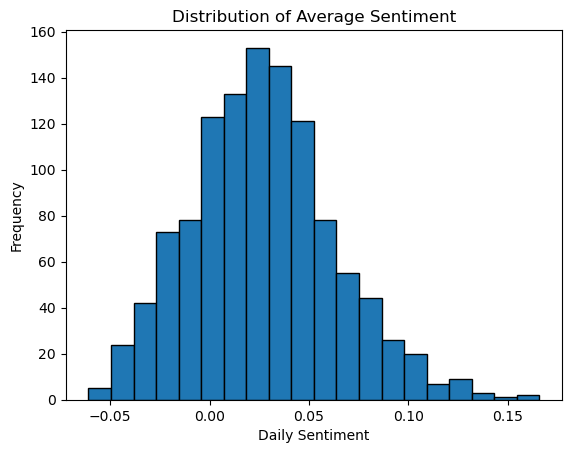

In [79]:
import pandas as pd
import matplotlib.pyplot as plt



# Read the CSV file into a pandas DataFrame
df = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\daily_finbert_sorted_TSLA_06_2020_to_06_2023.csv')

# Plot the distribution of the 'daily_sentiment' column
plt.hist(df['daily_sentiment'], bins=20, edgecolor='black')
plt.xlabel('Daily Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Average Sentiment')
plt.show()


## 10. Yahoo Finance to download Stock Price Data

In [80]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Procter & Gamble (PG)
ticker_symbol = "TSLA"

# Define the date range
start_date = "2020-05-30"
end_date = "2023-07-01"

# Get historical stock price data from Yahoo Finance
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Save the stock price data to a CSV file
stock_data.to_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_stock_prices_2020-05-30_to_2023-06-30.csv')

# Display a message to indicate successful saving
print("Stock price data saved")


[*********************100%***********************]  1 of 1 completed
Stock price data saved


In [37]:
df = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\5.5_NVDA\NVDA_stock_prices_2020-05-30_to_2023-06-30.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-06-01,88.332497,88.407501,86.894997,88.062500,87.779907,38987600
1,2020-06-02,87.962502,88.372498,86.580002,88.252502,87.969307,39132000
2,2020-06-03,88.222504,88.662498,87.000000,87.695000,87.413582,36544000
3,2020-06-04,87.279999,89.432503,86.775002,87.665001,87.423576,42428000
4,2020-06-05,87.945000,89.970001,87.080002,89.199997,88.954308,48174800


In [82]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
772,2023-06-26,250.070007,258.369995,240.699997,241.050003,241.050003,179990600
773,2023-06-27,243.240005,250.389999,240.850006,250.210007,250.210007,164968200
774,2023-06-28,249.699997,259.880005,248.889999,256.239990,256.239990,159770800
775,2023-06-29,258.029999,260.739990,253.610001,257.500000,257.500000,131283400
776,2023-06-30,260.600006,264.450012,259.890015,261.769989,261.769989,112267600


## 11. Merging both files and save as csv

In [83]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Read the CSV files into pandas DataFrames
stock_data = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_stock_prices_2020-05-30_to_2023-06-30.csv')
sentiment_data = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\daily_finbert_sorted_TSLA_06_2020_to_06_2023.csv')

# Step 2: Merge the DataFrames based on the 'Date' column
merged_data = sentiment_data.merge(stock_data, left_on='time', right_on='Date', how='inner')

# Step 3: Calculate the daily stock price change as the difference between "Adj Close" on consecutive days
merged_data['daily_price_change'] = merged_data['Adj Close'].diff()

# Step 4: Select and reorder the columns for the final DataFrame
final_data = merged_data[['Date', 'daily_sentiment', 'Adj Close', 'daily_price_change']]

# Step 5: Save the final DataFrame to a new CSV file
final_data.to_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_merged_data.csv', index=False)

print(f"Merged data is saved")


Merged data is saved


In [84]:
df = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_merged_data.csv')
print(df.head())
print(df.tail())

         Date  daily_sentiment  Adj Close  daily_price_change
0  2020-06-01         0.024002  59.873333                 NaN
1  2020-06-02         0.026834  58.770668           -1.102665
2  2020-06-03         0.049675  58.863998            0.093330
3  2020-06-04         0.019691  57.625332           -1.238667
4  2020-06-05         0.009622  59.043999            1.418667
           Date  daily_sentiment   Adj Close  daily_price_change
772  2023-06-26        -0.005561  241.050003          -15.550003
773  2023-06-27         0.031697  250.210007            9.160004
774  2023-06-28         0.040631  256.239990            6.029984
775  2023-06-29         0.035257  257.500000            1.260010
776  2023-06-30         0.065728  261.769989            4.269989


## 12. Graph Price and Sentiment 

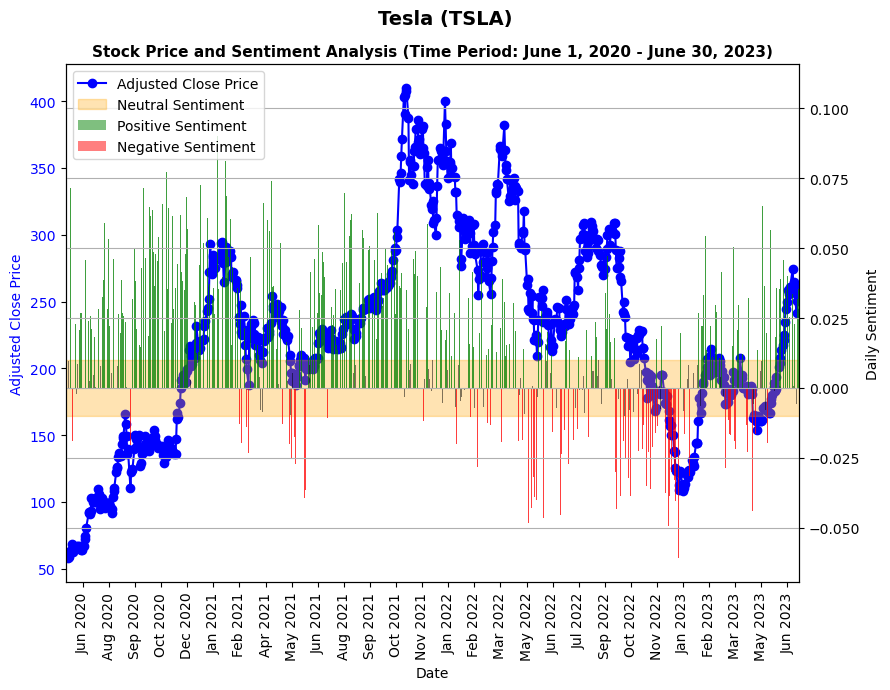

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import make_interp_spline

# Step 1: Read the CSV file into a pandas DataFrame
data = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_merged_data.csv')

# Step 2: Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Step 3: Create the plot with larger figure size and improved layout
fig, ax1 = plt.subplots(figsize=(9, 7))

# Plot Adj Close as a line plot on the primary y-axis
ax1.plot(data['Date'], data['Adj Close'], color='blue', label='Adjusted Close Price', marker='o')
ax1.set_xlabel('Date')
ax1.set_ylabel('Adjusted Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Rotate x-axis tick labels for better visibility
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(MaxNLocator(nbins=32))  # Adjust the number of ticks as needed
plt.xticks(rotation=90)

# Create a secondary y-axis for daily_sentiment
ax2 = ax1.twinx()

# Determine colors based on sentiment values
colors = ['red' if sentiment < -0.01 else 'green' if sentiment > 0.01 else 'black' for sentiment in data['daily_sentiment']]

# Plot the neutral sentiment as a shaded region
ax2.fill_between(data['Date'], -0.01, 0.01, color='orange', alpha=0.3, label='Neutral Sentiment')

# Plot the positive sentiment in green
ax2.bar(data['Date'], data['daily_sentiment'], color=colors, alpha=0.5)
ax2.bar(data['Date'], [sentiment if sentiment > 0.01 else 0 for sentiment in data['daily_sentiment']], color='green', alpha=0.5, label='Positive Sentiment')

# Plot the negative sentiment in red
ax2.bar(data['Date'], [sentiment if sentiment < -0.01 else 0 for sentiment in data['daily_sentiment']], color='red', alpha=0.5, label='Negative Sentiment')

ax2.set_ylabel('Daily Sentiment', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Customize the plot title, subtitle, and third line
plt.suptitle('Tesla (TSLA)', fontsize=14, fontweight='bold')  # Adjusted y position
plt.title('Stock Price and Sentiment Analysis (Time Period: June 1, 2020 - June 30, 2023)', fontsize=11,fontweight='bold', ha='center')

# Set x-axis limits
plt.xlim(pd.Timestamp('2020-06-01'), pd.Timestamp('2023-06-30'))

# Customize other plot settings
plt.tight_layout()
plt.grid(True)

# Combine the legends from both y-axes and place on the right-hand corner
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')


# Save the plot as an image file (e.g., PNG)
plt.savefig(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_Price_Sentiment_Analysis.png')

# Show the plot
plt.tight_layout()
plt.show()


In [88]:
import pandas as pd
from scipy.stats import spearmanr

# Step 1: Read the CSV file into a pandas DataFrame
data = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_merged_data.csv')

# Drop rows with NaN values in the specified columns
data_cleaned = data.dropna(subset=['daily_sentiment', 'daily_price_change'])

# Calculate Spearman correlation and p-value
correlation, p_value = spearmanr(data_cleaned['daily_sentiment'], data_cleaned['daily_price_change'])

# Create a DataFrame to display the results
correlation_results = pd.DataFrame({
    'Correlation': [correlation],
    'P-value': [p_value]
})

# Print the results
print(correlation_results)


   Correlation       P-value
0     0.499108  4.035004e-50


## 13. Grpah the Correlation 
###  Spearman Correlation Coefficient

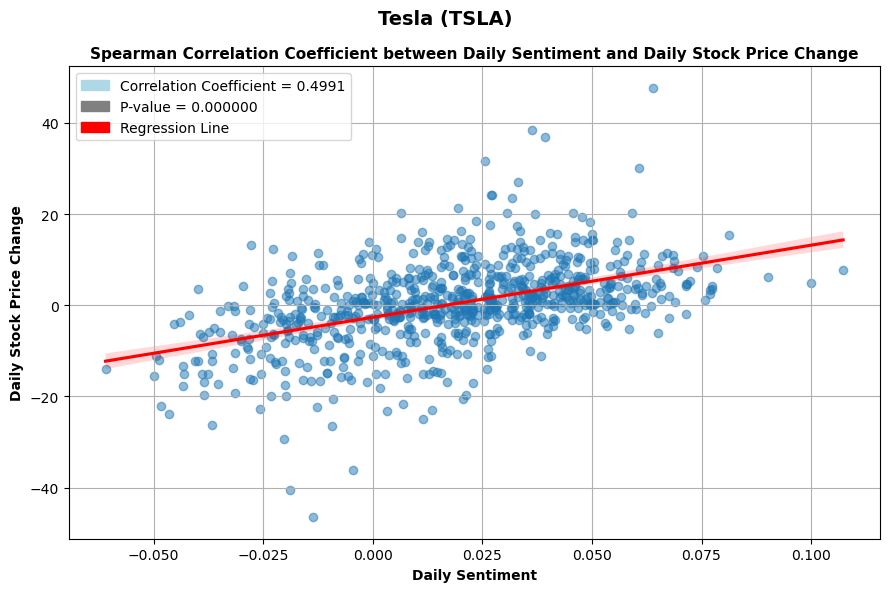

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import matplotlib.patches as mpatches

# Step 1: Read the CSV file into a pandas DataFrame
data = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_merged_data.csv')

# Drop rows with NaN values in the specified columns
data_cleaned = data.dropna(subset=['daily_sentiment', 'daily_price_change'])

# Calculate Spearman correlation and p-value
correlation, p_value = spearmanr(data_cleaned['daily_sentiment'], data_cleaned['daily_price_change'])

# Create a scatter plot with a red regression line
plt.figure(figsize=(9, 6))
sns.regplot(x='daily_sentiment', y='daily_price_change', data=data_cleaned, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.suptitle('Tesla (TSLA)', fontsize=14, fontweight='bold')
plt.title("Spearman Correlation Coefficient between Daily Sentiment and Daily Stock Price Change", fontsize=11, fontweight='bold')
plt.xlabel('Daily Sentiment', fontsize=10, fontweight='bold')
plt.ylabel('Daily Stock Price Change', fontsize=10, fontweight='bold')
plt.grid(True)

# Create legend handles and labels
handles = [
    
    mpatches.Patch(color='lightblue', label=f'Correlation Coefficient = {correlation:.4f}'),
    mpatches.Patch(color='grey', label=f'P-value = {p_value:.6f}'),
    mpatches.Patch(color='red', label=f'Regression Line'),
]

# Add the custom legend with adjusted placement
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_spearman_correlation_plot.png')

# Show the plot
plt.show()


## Pearson Correlation Coefficient

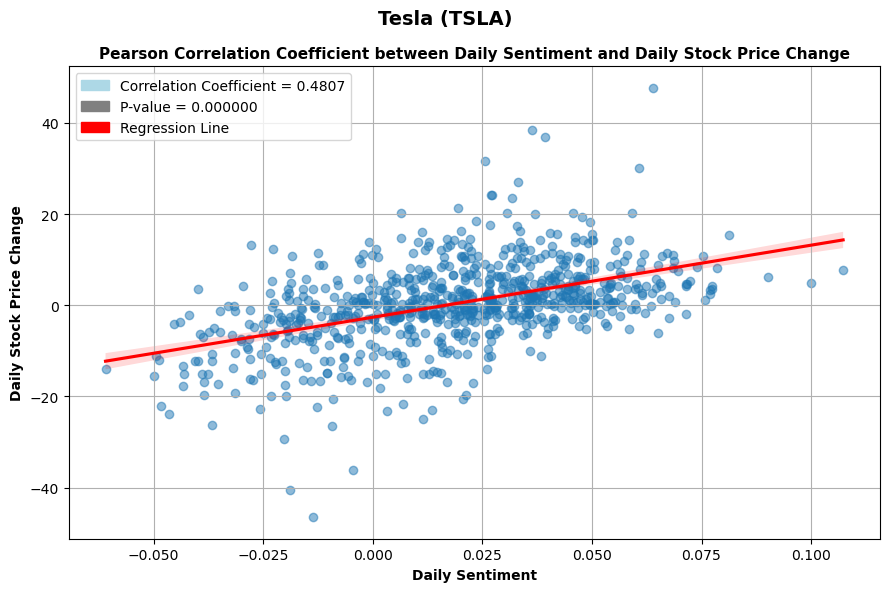

In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import matplotlib.patches as mpatches

# Step 1: Read the CSV file into a pandas DataFrame
data = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_merged_data.csv')

# Drop rows with NaN values in the specified columns
data_cleaned = data.dropna(subset=['daily_sentiment', 'daily_price_change'])

# Calculate Pearson correlation and p-value
correlation, p_value = pearsonr(data_cleaned['daily_sentiment'], data_cleaned['daily_price_change'])

# Create a scatter plot with a red regression line
plt.figure(figsize=(9, 6))
sns.regplot(x='daily_sentiment', y='daily_price_change', data=data_cleaned, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.suptitle('Tesla (TSLA)', fontsize=14, fontweight='bold')
plt.title("Pearson Correlation Coefficient between Daily Sentiment and Daily Stock Price Change", fontsize=11, fontweight='bold')
plt.xlabel('Daily Sentiment', fontsize=10, fontweight='bold')
plt.ylabel('Daily Stock Price Change', fontsize=10, fontweight='bold')
plt.grid(True)

# Create legend handles and labels
handles = [
    
    mpatches.Patch(color='lightblue', label=f'Correlation Coefficient = {correlation:.4f}'),
    mpatches.Patch(color='grey', label=f'P-value = {p_value:.6f}'),
    mpatches.Patch(color='red', label=f'Regression Line')
]

# Add the custom legend with adjusted placement
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_pearson_correlation_plot.png')

# Show the plot
plt.show()


## Kendall's Tau Correlation Coefficient

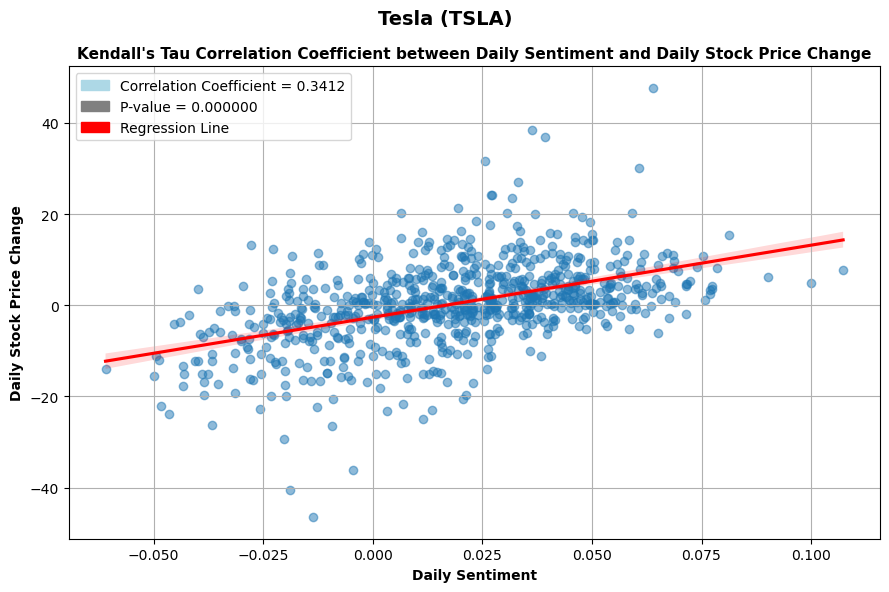

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import matplotlib.patches as mpatches

# Step 1: Read the CSV file into a pandas DataFrame
data = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_merged_data.csv')

# Drop rows with NaN values in the specified columns
data_cleaned = data.dropna(subset=['daily_sentiment', 'daily_price_change'])

# Calculate Kendall's Tau correlation and p-value
correlation, p_value = kendalltau(data_cleaned['daily_sentiment'], data_cleaned['daily_price_change'])

# Create a scatter plot with a red regression line
plt.figure(figsize=(9, 6))
sns.regplot(x='daily_sentiment', y='daily_price_change', data=data_cleaned, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'})
plt.suptitle('Tesla (TSLA)', fontsize=14, fontweight='bold')
plt.title("Kendall's Tau Correlation Coefficient between Daily Sentiment and Daily Stock Price Change", fontsize=11, fontweight='bold')
plt.xlabel('Daily Sentiment', fontsize=10, fontweight='bold')
plt.ylabel('Daily Stock Price Change', fontsize=10, fontweight='bold')
plt.grid(True)

# Create legend handles and labels
handles = [
    mpatches.Patch(color='lightblue', label=f'Correlation Coefficient = {correlation:.4f}'),
    mpatches.Patch(color='grey', label=f'P-value = {p_value:.6f}'),
    mpatches.Patch(color='red', label=f'Regression Line')
]

# Add the custom legend with adjusted placement
plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(0, 1))

plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_kendall_correlation_plot.png')

# Show the plot
plt.show()


## 14. Distribution of Daily Sentiment and Daily Stock Price Change

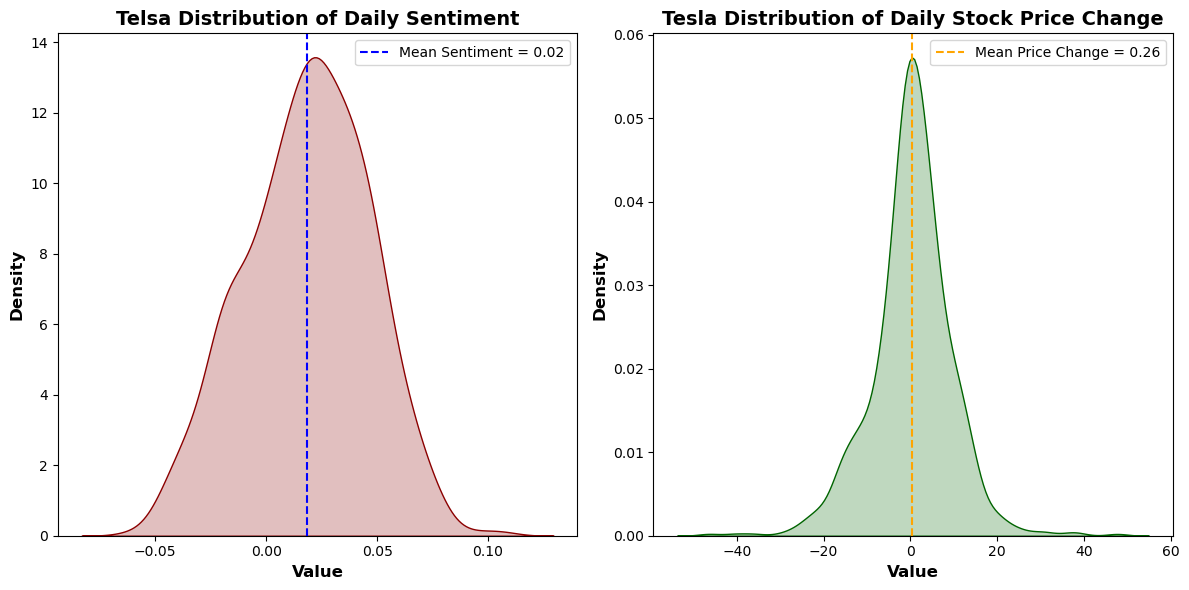

In [96]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Read the CSV file into a pandas DataFrame
data = pd.read_csv(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_merged_data.csv')

# Calculate mean values
mean_sentiment = data['daily_sentiment'].mean()
mean_stock_change = data['daily_price_change'].mean()

# Create a figure and axes with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of Average Sentiment
sns.kdeplot(data['daily_sentiment'], ax=axes[0], color='darkred', shade=True)
axes[0].axvline(x=mean_sentiment, color='blue', linestyle='dashed', label=f'Mean Sentiment = {mean_sentiment:.2f}')
axes[0].set_title('Telsa Distribution of Daily Sentiment', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Value', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Density', fontsize=12, fontweight='bold')

# Plot distribution of Daily Stock Price Change
sns.kdeplot(data['daily_price_change'], ax=axes[1], color='darkgreen', shade=True)
axes[1].axvline(x=mean_stock_change, color='orange', linestyle='dashed', label=f'Mean Price Change = {mean_stock_change:.2f}')
axes[1].set_title('Tesla Distribution of Daily Stock Price Change', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Value', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Density', fontsize=12, fontweight='bold')

# Add legends to each subplot
axes[0].legend()
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Save the plot as a PNG image
plt.savefig(r'C:\Users\sahma\Desktop\Thises\TSLA\TSLA_distribution_plot.png')

# Show the plot
plt.show()
